# Goal

Train a model that is as accurate as possible to predict the survival rates of passengers.

# Import Libraries

In [68]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score 

from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

In [2]:
titanic_train = pd.read_csv('data/train.csv')
titanic_train.columns = titanic_train.columns.str.lower()
titanic_train.head(2)

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


- survival: Survival (0 = No; 1 = Yes)
- pclass: Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)
- name: Name
- sex: Sex
- age: Age
- sibsp: Number of Siblings/Spouses Aboard
- parch: Number of Parents/Children Aboard
- ticket: Ticket Number
- fare: Passenger Fare
- cabin: Cabin
- embarked: Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)

## Quick Analysis

The training dataset includes information regarding, passenger ID, survived, class, name, sex, age, siblings/spouses on board, Parents with children on board, ticket #, fare paid, cabin #, and where they embarked.  

I believe that Class, sex, age, siblings/spouse, cabin and where they embarked will affect the survival rates for these reasons:
- class: better access to information and lifeboats, 
- sex: more females survived than males (bias), 
- age: as the younger you are the harder you will struggle to survive and also be placed on a lifeboat, 
- siblings/spouse: those that travel together would look after each other, and 
- cabin: perhaps the location affects access to lifeboats
- embarkation: possible socio-economic reasons or length of trip depends what cabin is purchased?

I will see through Exploratory Data Analysis (EDA) whether my initial estimates hold any merit or if other correlations emerge.

# Exploratory Data Analysis (EDA)

In [3]:
survived=titanic_train.groupby('survived').count()
survived

,passengerid,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
survived,,,,,,,,,,,
0,549,549,549,549,424,549,549,549,549,68,549
1,342,342,342,342,290,342,342,342,342,136,340


Text(0.5, 0, 'Survived (0 = Dead,1 = Survived)')

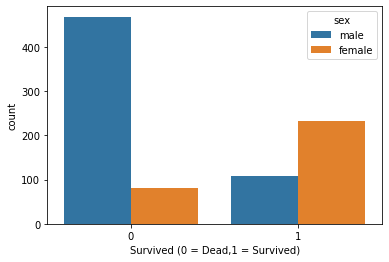

In [4]:
sns.countplot(data=titanic_train, x ='survived', hue = 'sex')
plt.xlabel('Survived (0 = Dead,1 = Survived)' )


Text(0.5, 0, 'Survived (0 = Dead,1 = Survived)')

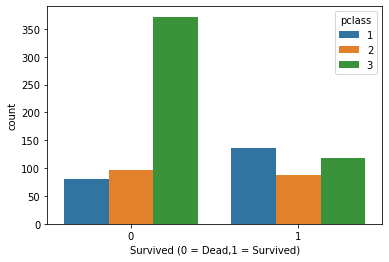

In [5]:
sns.countplot(x="survived",
              hue="pclass",
              data=titanic_train)
plt.xlabel('Survived (0 = Dead,1 = Survived)' )

In [6]:
titanic_train.corr()

,passengerid,survived,pclass,age,sibsp,parch,fare
passengerid,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
sibsp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


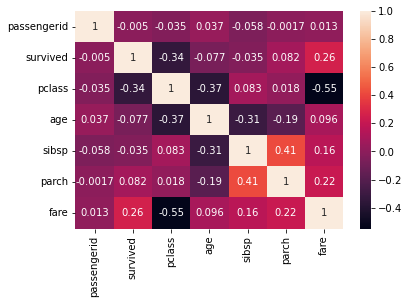

In [7]:
#This is a heatmap of the above information that makes it easier to see the features
#that correlate with each other (if any).
sns.heatmap(titanic_train.corr(), annot=True)
plt.show()

With the above heatmap, it is easy to see the features with the strongest positive correlations (orange) and the features with the strongest negative correlations (black). 

We can conclude that there are strong positive correlations between SibSp and Parch—and that makes sense because children often have siblings, and parents and children often travel together. We can also see that Pclass and Fare are strongly negatively correlated—that makes sense because 1st class tickets are more expensive than lower class tickets, meaning as class goes down (closer to 1) the fare goes up. Finally Age and Pclass are moderately negatively correlated—since richer people are generally older.

In [8]:
#Sex was not included in the above correlation as it is a string.  
#We can use .get_dummies().  This converts a categorical variable into 
#dummy (binary) variables

titanic_train['sex'].str.get_dummies().corrwith(titanic_train['survived']/titanic_train['survived'].max())

female    0.543351
male     -0.543351
dtype: float64

This indicates that being male was strongly negatively correlated with the survival rate and the opposite for women.

In [9]:
# number of null values in dataset
titanic_train.isnull().sum() 

passengerid      0
survived         0
pclass           0
name             0
sex              0
age            177
sibsp            0
parch            0
ticket           0
fare             0
cabin          687
embarked         2
dtype: int64

We can see from the above listing that there is 177 missing values in age.  I believe age is an important factor in survival because those that were able to fend for themselves (not elderly or a small child) would stand a better chance of surviving.  I will try and find the mean age by sex and class to substitute the missing values.

There are too many missing values in the cabin column and I will exclude this column from my analysis. 

There are 2 missing entries on embarked. I will see if it is easy to establish where they embarked.  If not, I will exclude them from the analysis.

Text(0.5, 1.0, 'Missing values heatmap')

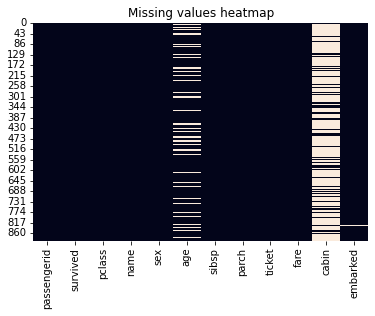

In [10]:
sns.heatmap(titanic_train.isnull(), cbar = False).set_title("Missing values heatmap")

# Data Cleanup

Dealing with missing values:
-  Drop data (whole row or column), or
-  Replace data

In [11]:
#Check for duplicated passenger info.  There isn't any to deal with.
duplications = titanic_train.duplicated()
duplications

0      False
1      False
2      False
3      False
4      False
       ...  
886    False
887    False
888    False
889    False
890    False
Length: 891, dtype: bool

In [12]:
titanic_train.head(2)

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [13]:
titanic_train['fare']=titanic_train['fare'].astype(int)

In [14]:
titanic_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   passengerid  891 non-null    int64  
 1   survived     891 non-null    int64  
 2   pclass       891 non-null    int64  
 3   name         891 non-null    object 
 4   sex          891 non-null    object 
 5   age          714 non-null    float64
 6   sibsp        891 non-null    int64  
 7   parch        891 non-null    int64  
 8   ticket       891 non-null    object 
 9   fare         891 non-null    int64  
 10  cabin        204 non-null    object 
 11  embarked     889 non-null    object 
dtypes: float64(1), int64(6), object(5)
memory usage: 83.7+ KB


# Data Engineering

## Fill in Missing Port of Embarkation Values

In [15]:
titanic_train['embarked'].value_counts()

S    644
C    168
Q     77
Name: embarked, dtype: int64

In [16]:
missing_embarked = titanic_train[pd.isnull(titanic_train.embarked)]
missing_embarked

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80,B28,NaN


In [17]:
#the missing info belong to 2 females, I will ascertain the mean fare by class for
#females only
female_only = titanic_train[titanic_train['sex'] == 'female'].groupby\
    (["embarked","pclass"])["fare"].mean()
female_only

embarked  pclass
C         1         115.186047
          2          24.857143
          3          14.347826
Q         1          90.000000
          2          12.000000
          3           9.666667
S         1          98.583333
          2          21.746269
          3          18.147727
Name: fare, dtype: float64

The above data are the mean prices for females grouped by ports of embarkations.  As both passengers with missing embarkation information paid 80 and are in first class, I will insert Q as their embarkation port as all other first class fares are well above the 80 that was paid.

In [18]:
titanic_train["embarked"] = titanic_train["embarked"].fillna("Q")

In [19]:
titanic_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   passengerid  891 non-null    int64  
 1   survived     891 non-null    int64  
 2   pclass       891 non-null    int64  
 3   name         891 non-null    object 
 4   sex          891 non-null    object 
 5   age          714 non-null    float64
 6   sibsp        891 non-null    int64  
 7   parch        891 non-null    int64  
 8   ticket       891 non-null    object 
 9   fare         891 non-null    int64  
 10  cabin        204 non-null    object 
 11  embarked     891 non-null    object 
dtypes: float64(1), int64(6), object(5)
memory usage: 83.7+ KB


## Fill in Missing Age Values

In [20]:
by_sex_class = titanic_train.groupby(['sex', 'pclass'])

In [21]:
def impute_median(series):
    return series.fillna(series.median())

In [22]:
titanic_train.age = by_sex_class['age'].transform(impute_median)

## Factorizing Features

In [23]:
#I will factorise sex or make the words male/female be represented by numbers 
#(male = 0, female = 1)
titanic_train['sex_f'] = pd.factorize(titanic_train['sex'])[0]

In [24]:
#I will factorise port of embarkation (S = 0, C = 1, Q = 2)
#(male = 0, female = 1)
titanic_train['embarked_f'] = pd.factorize(titanic_train['embarked'])[0]
titanic_train[['embarked', 'embarked_f']]

,embarked,embarked_f
0,S,0
1,C,1
2,S,0
3,S,0
4,S,0
...,...,...
886,S,0
887,S,0
888,S,0
889,C,1


In [25]:
#drop the passengerid and cabin column as I feel they won't add much to the prediction.
titanic_train=titanic_train.drop(['passengerid','cabin'], axis=1)
titanic_train.head(2)

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,embarked,sex_f,embarked_f
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7,S,0,0
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71,C,1,1


array([[<AxesSubplot:title={'center':'survived'}>,
        <AxesSubplot:title={'center':'pclass'}>,
        <AxesSubplot:title={'center':'age'}>],
       [<AxesSubplot:title={'center':'sibsp'}>,
        <AxesSubplot:title={'center':'parch'}>,
        <AxesSubplot:title={'center':'fare'}>],
       [<AxesSubplot:title={'center':'sex_f'}>,
        <AxesSubplot:title={'center':'embarked_f'}>, <AxesSubplot:>]],
      dtype=object)

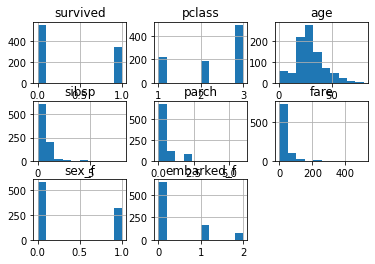

In [26]:
titanic_train.hist()

## Continuation

In [27]:
titanic_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   survived    891 non-null    int64  
 1   pclass      891 non-null    int64  
 2   name        891 non-null    object 
 3   sex         891 non-null    object 
 4   age         891 non-null    float64
 5   sibsp       891 non-null    int64  
 6   parch       891 non-null    int64  
 7   ticket      891 non-null    object 
 8   fare        891 non-null    int64  
 9   embarked    891 non-null    object 
 10  sex_f       891 non-null    int64  
 11  embarked_f  891 non-null    int64  
dtypes: float64(1), int64(7), object(4)
memory usage: 83.7+ KB


My initial thoughts have been verified by the above analysis.  I will use the 
following information to train/test the data for predicting the survival rate of passengers.
-  pclass (class), 
-  sex_f (sex factorized), 
-  age, 
-  sibsp (siblings/spouse),
-  parch (parents of children on board)
-  fare
-  embarked_f (where they embarked)



# Train/Test Split

In [28]:
#drop the column "survived" from file as we are creating a ML to predict
#y is true data (Y_true) the survivors from the original file, we will try and predict Y_new
X = titanic_train[['pclass','age', 'sibsp', 'parch', 'fare', 'sex_f', 'embarked_f']]
y = titanic_train["survived"]

In [29]:
X.shape, y.shape

((891, 7), (891,))

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

In [31]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((712, 7), (179, 7), (712,), (179,))

# Modelling

I am using Supervised Machine Learning models as we know the answer of who survived and who died. Since we have a classification issue (yes or no, binary 0 or 1) we can use models such as: 
-  Logistic Regression
-  the Random Forest Classification
-  Support Vector Machine (SVM)
-  Naive Bayes
-  k-NN
-  or other deep learning models

I will do a combination of Logistic Regression, Random Forest Classification, and Support Vector Machine and compare how accurate each model is to each other.

## Logistic Regression Model

The Logistic Regression Model (LRM) uses the binary cross entropy (or log loss) as a loss function. The loss function helps measure how well the model fits all of the training datapoints. The loss function takes the actual values of y from the training data and the current predictions and returns a single number.  The closer this number is to zero, the better the model fits the datapoints.

In [32]:
X_trainLR, X_testLR, y_trainLR, y_testLR = train_test_split(X,y, test_size = 0.20)

In [33]:
# check the shape
X_trainLR.shape, y_trainLR.shape, X_testLR.shape, y_testLR.shape

((712, 7), (712,), (179, 7), (179,))

In [34]:
# build and fit the model
m_lgr = LogisticRegression(max_iter=1000) 

m_lgr.fit(X_trainLR,y_trainLR)

LogisticRegression(max_iter=1000)

In [35]:
## Get the estimated probabilities
#estim_prob = m_lgr.predict_proba(X_trainLR)
#estim_prob

In [36]:
# Calculate the prediction
y_predLR = m_lgr.predict(X_trainLR)
y_predLR.shape

(712,)

In [57]:
# Calculate the accuracy
accuracy = m_lgr.score(X_trainLR,y_trainLR)

In [59]:
print(f"""The Logistic regression has achieved an: \n 
accuracy = {round(accuracy,2)}\n
precision = {round(precision_score(y_trainLR,y_predLR),2)} \n 
recall = {round(recall_score(y_trainLR,y_predLR),2)}\n
f1 = {round(f1_score(y_trainLR,y_predLR),2)}""")

The Logistic regression has achieved an: 
 
accuracy = 0.81

precision = 0.78 
 
recall = 0.72

f1 = 0.75


Precision indicates the quality of a positive prediction made by the model. Of the total positive predicted values, how many of them are actually positive (the number of true positives plus the number of false positives).

The recall is calculated as the ratio between the number of Positive samples correctly classified as Positive to the total number of Positive samples. The higher the recall, the more positive samples detected (less negative samples misclassified).

F1-score sums up the performance of a model by combining precision and recall.

### Cross Validation on Logistic Regression

In [83]:
cross_accuracy_logLR = cross_val_score(m_lgr,  #estimator: the model that you want to evalueate
                                     X_trainLR, # the training data
                                     y_trainLR,  # the training data
                                     cv = 5 , # number of cross validation datasets, k-folds
                                     scoring = 'accuracy' # evaluation metric

)

CAL_LR=np.round_(cross_accuracy_logLR, 2)
CAL_LR

array([0.81, 0.78, 0.82, 0.79, 0.85])

In [39]:
confLR = confusion_matrix(y_trainLR, y_predLR)
confLR

array([[383,  56],
       [ 76, 197]])

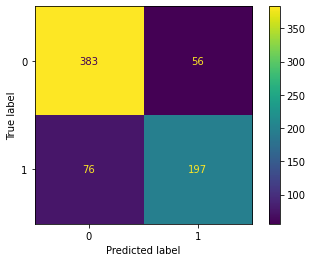

In [40]:
cmLR = confusion_matrix(y_trainLR, y_predLR, labels=m_lgr.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cmLR,
                              display_labels=m_lgr.classes_)
disp.plot()
plt.show()

## RandomForest

In [41]:
X_trainRF, X_testRF, y_trainRF, y_testRF = train_test_split(X,y, test_size = 0.20)

In [42]:
X_trainRF.shape, X_testRF.shape, y_trainRF.shape, y_testRF.shape

((712, 7), (179, 7), (712,), (179,))

In [43]:
rfc = RandomForestClassifier(n_estimators=70, max_depth=4)    #Hyperparam: n_estimators(number of trees)
rfc.fit(X_trainRF, y_trainRF)

RandomForestClassifier(max_depth=4, n_estimators=70)

In [44]:
y_predRF = rfc.predict(X_trainRF)
y_predRF.shape

(712,)

In [45]:
round(rfc.score(X_trainRF, y_trainRF),3)

0.834

In [46]:
#round(rfc.score(X_testRF, y_testRF),3)

In [47]:
importance = rfc.feature_importances_
importance

array([0.14396834, 0.1078325 , 0.05550266, 0.03939843, 0.16038306,
       0.47006868, 0.02284633])

In [48]:
# summarize feature importance
for i,v in enumerate(importance):
        print('Feature: %0d, Score: %.5f' % (i,   v))

Feature: 0, Score: 0.14397
Feature: 1, Score: 0.10783
Feature: 2, Score: 0.05550
Feature: 3, Score: 0.03940
Feature: 4, Score: 0.16038
Feature: 5, Score: 0.47007
Feature: 6, Score: 0.02285


([<matplotlib.axis.XTick at 0x1415ac070>,
 [Text(0.1439683423907804, 0, 'Feature 0'),
  Text(0.10783249912200522, 0, 'Feature 1'),
  Text(0.055502659524267965, 0, 'Feature 2'),
  Text(0.039398426965673826, 0, 'Feature 3'),
  Text(0.1603830632785654, 0, 'Feature 4'),
  Text(0.47006867882991604, 0, 'Feature 5'),
  Text(0.022846329888791053, 0, 'Feature 6')])

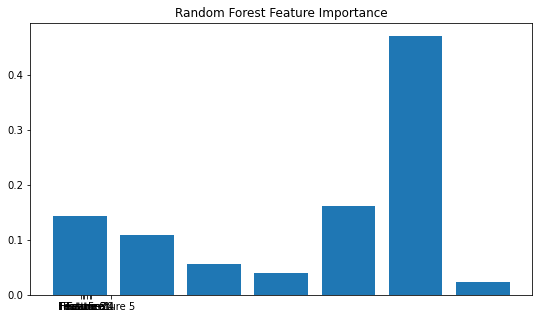

In [49]:
fig = plt.figure(figsize=(9,5))

plt.bar([x for x in range(len(importance))], importance)
plt.title('Random Forest Feature Importance')
plt.xticks(importance, ('Feature 0', 'Feature 1', 'Feature 2', 'Feature 3', 'Feature 4', 'Feature 5', 'Feature 6'))

In [60]:
# Calculate the accuracy
accuracyRF = rfc.score(X_trainRF,y_trainRF)

In [61]:
print(f"""The Random Forest Model has achieved an: \n 
accuracy = {round(accuracyRF,2)}\n
precision = {round(precision_score(y_trainRF,y_predRF),2)} \n 
recall = {round(recall_score(y_trainRF,y_predRF),2)}\n
f1 = {round(f1_score(y_trainRF,y_predRF),2)}""")

The Random Forest Model has achieved an: 
 
accuracy = 0.83

precision = 0.84 
 
recall = 0.72

f1 = 0.77


### Cross Validation RFC

In [84]:
cross_accuracy_logRFC = cross_val_score(rfc,  #estimator: the model that you want to evalueate
                                     X_trainRF, # the training data
                                     y_trainRF
                                        ,  # the training data
                                     cv = 5 , # number of cross validation datasets, k-folds
                                     scoring = 'accuracy' # evaluation metric

)

CAL_RFC = np.round_(cross_accuracy_logRFC, 2)
CAL_RFC

array([0.79, 0.8 , 0.81, 0.8 , 0.81])

In [52]:
conf = confusion_matrix(y_trainRF, y_predRF)
conf

array([[392,  39],
       [ 79, 202]])

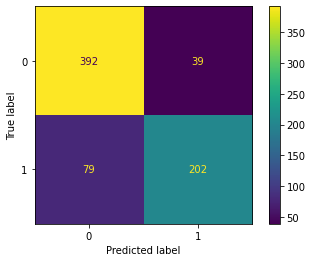

In [53]:
cm = confusion_matrix(y_trainRF, y_predRF, labels=rfc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=rfc.classes_,
                                )
disp.plot()
plt.show()

# Support Vector Machine

In [62]:
X_trainSV, X_testSV, y_trainSV, y_testSV = train_test_split(X,y, test_size = 0.20)

In [69]:
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(X_trainSV, y_trainSV)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto'))])

In [76]:
print(f'Train Score = {round(clf.score(X_trainSV, y_trainSV), 2)},\nTest Score = {round(clf.score(X_testSV, y_testSV), 2)}')

Train Score = 0.85,
Test Score = 0.83


## Cross Validation on SVM

In [82]:
cross_accuracy_logSV = cross_val_score(clf,  #estimator: the model that you want to evalueate
                                     X_trainSV, # the training data
                                     y_trainSV,  # the training data
                                     cv = 5 , # number of cross validation datasets, k-folds
                                     scoring = 'accuracy' # evaluation metric

)

CAL_SV=np.round_(cross_accuracy_logSV, 2)

In [85]:
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest Classifier', 'Support Vector Machine'],
    
     'Cross_Accuracy_Log': [CAL_LR, CAL_RFC, CAL_SV]
})

In [86]:
results

,Model,Cross_Accuracy_Log
0,Logistic Regression,"[0.81, 0.78, 0.82, 0.79, 0.85]"
1,Random Forest Classifier,"[0.79, 0.8, 0.81, 0.8, 0.81]"
2,Support Vector Machine,"[0.85, 0.82, 0.85, 0.78, 0.82]"


The Support Vector Machine had the best overall results and I will use this model for my Kaggle Submission.